<a href="https://colab.research.google.com/github/HossamElsrah/Ad-Click-Prediction/blob/main/Copy_of_Ad_Click_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
!pip install category_encoders

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
from sklearn.model_selection import train_test_split , GridSearchCV , StratifiedKFold , cross_val_score , cross_validate
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from category_encoders import BinaryEncoder
from sklearn.metrics import confusion_matrix , classification_report , f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier , plot_tree
from sklearn.ensemble import VotingClassifier ,  RandomForestClassifier , AdaBoostClassifier , GradientBoostingClassifier
from xgboost import XGBClassifier

# Set the theme for seaborn
sns.set_theme()

# Suppress warnings
warnings.filterwarnings('ignore')

# Data Loading

In [ ]:
data = pd.read_csv("/content/advertising.csv")
data.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:11,0
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:02,0
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:42,0
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:19,0
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:18,0


In [ ]:
#info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  1000 non-null   float64
 1   Age                       1000 non-null   int64  
 2   Area Income               1000 non-null   float64
 3   Daily Internet Usage      1000 non-null   float64
 4   Ad Topic Line             1000 non-null   object 
 5   City                      1000 non-null   object 
 6   Male                      1000 non-null   int64  
 7   Country                   1000 non-null   object 
 8   Timestamp                 1000 non-null   object 
 9   Clicked on Ad             1000 non-null   int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 78.2+ KB


In [ ]:
#describe
data.describe()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Clicked on Ad
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000
mean,65.000200,36.009000,55000.000080,180.000100,0.481000,0.50000
std,15.853615,8.785562,13414.634022,43.902339,0.499889,0.50025
min,32.600000,19.000000,13996.500000,104.780000,0.000000,0.00000
25%,51.360000,29.000000,47031.802500,138.830000,0.000000,0.00000
50%,68.215000,35.000000,57012.300000,183.130000,0.000000,0.50000
75%,78.547500,42.000000,65470.635000,218.792500,1.000000,1.00000
max,91.430000,61.000000,79484.800000,269.960000,1.000000,1.00000


In [ ]:
#describe(objects)
data.describe(include="object")

,Ad Topic Line,City,Country,Timestamp
count,1000,1000,1000,1000
unique,1000,969,237,1000
top,Cloned 5thgeneration orchestration,Lisamouth,France,2016-03-27 00:53:11
freq,1,3,9,1


# Data Preperation



  

1.   we need to change datatype of Timestamp column







In [ ]:
#convert the datatype from "opject"to "datetime"
data["Timestamp"] = pd.to_datetime(data["Timestamp"])

2.   missing values


In [ ]:
#check null values
data.isnull().sum()

,0
Daily Time Spent on Site,0
Age,0
Area Income,0
Daily Internet Usage,0
Ad Topic Line,0
City,0
Male,0
Country,0
Timestamp,0
Clicked on Ad,0


3.   Dublicated Values


In [ ]:
#check dublicated values
data.duplicated().sum()

0

4. Rename The "Male" Column To Gender

In [ ]:
#rename "Male" column
data.rename(columns={"Male": "Gender"}, inplace=True)

#Rewriting the Values of "Male" column
data["Gender"] = data["Gender"].map({1: "Male", 0: "Female"})



**The Data Is Cleaned**



5.   Features Engineering


We need to extract some columns for analysis and check if they will be useful in the learning process
* I want to extract the total hours spent by users from the "Daily Time Spent on Site" column.
* I want to extract only the Month and The hour column from the 'Timestamp' column (I believe the year, day, and other components will not be useful for this data).



In [ ]:
#check if The total daily time more than 2 hours or not
data['Daily Time Spent on Site'].unique()

array([68.95, 80.23, 69.47, 74.15, 68.37, 59.99, 88.91, 66.  , 74.53,
       69.88, 47.64, 83.07, 69.57, 79.52, 42.95, 63.45, 55.39, 82.03,
       54.7 , 74.58, 77.22, 84.59, 41.49, 87.29, 41.39, 78.74, 48.53,
       51.95, 70.2 , 76.02, 67.64, 86.41, 59.05, 55.6 , 57.64, 84.37,
       62.26, 65.82, 50.43, 38.93, 84.98, 64.24, 82.52, 81.38, 80.47,
       37.68, 69.62, 85.4 , 44.33, 48.01, 73.18, 79.94, 33.33, 50.33,
       62.31, 80.6 , 65.19, 44.98, 77.63, 41.82, 85.61, 85.84, 72.08,
       86.06, 45.96, 62.42, 63.89, 35.33, 75.74, 78.53, 46.13, 69.01,
       55.35, 33.21, 38.46, 64.1 , 49.81, 82.73, 56.14, 55.13, 78.11,
       73.46, 56.64, 68.94, 70.79, 57.76, 77.51, 52.7 , 57.7 , 56.89,
       69.9 , 55.79, 70.03, 50.08, 43.67, 72.84, 45.72, 39.94, 35.61,
       79.71, 63.6 , 89.91, 68.18, 66.49, 80.49, 72.23, 42.39, 47.53,
       74.02, 66.63, 63.24, 71.  , 69.  , 76.99, 72.6 , 61.88, 84.45,
       88.97, 86.19, 49.58, 77.65, 37.75, 62.33, 79.57, 80.31, 89.05,
       70.41, 67.36,

In [ ]:
#function to convert the mins col to hours col
data['Daily Hours Spent on Site'] = data['Daily Time Spent on Site'] / 60

In [ ]:
#function to convert this hours col to object and be more Understandable
def categorize_hours(hours):
        if hours >= 1:
            return "More than 1 hour"
        elif hours >= 0.5:
            return "Less than 1 hour"
        else:
            return "less than half an hour"

        return data

data['Daily Hours Spent on Site'] = data['Daily Hours Spent on Site'].apply(categorize_hours)

In [ ]:
# Extract the month and hour
data['Month'] = data['Timestamp'].dt.month_name()
data['Hour'] = data['Timestamp'].dt.hour.apply(lambda x: f'{(x % 12) if x % 12 != 0 else 12} {"AM" if x < 12 else "PM"}')

In [ ]:
#show sample of data
data.sample()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Gender,Country,Timestamp,Clicked on Ad,Daily Hours Spent on Site,Month,Hour
650,83.66,38,68877.02,175.14,Profound dynamic attitude,East Debraborough,Female,Syrian Arab Republic,2016-02-18 03:58:36,0,More than 1 hour,February,3 AM


# EDA



## Univarite Analysis



We Need To ask ourself some Questions

1. What is the average daily time (in minutes) spent on the site?
2. What is the average age of people visiting the site?
3. What is the average Yearly income of the areas where users are located?
4. Which city and country do most of the users come from?
5. We need to know the most common gender of people visiting the site
6. What is the average daily time (in hours) spent on the site?
7. Which month has the highest site usage activity?
8. Which hour has the highest site usage activity?
9. What is the average of Daily Internet Usage by users?



In [ ]:
#Function to visualize the columns
def visualize_bar(column):

    """Visualizes the given column as a bar plot."""

    value_counts = data[column].value_counts().nlargest(10)
    plt.figure(figsize=(10, 6))
    value_counts.plot(kind='bar', color='navy')
    plt.title(f"Bar Plot of {column}")
    plt.xlabel(column)
    plt.ylabel("Count")
    plt.show()

In [ ]:
# Function to visualize the Continuous columns
def visualize_hist(column):

    """Visualizes the given column as a histogram."""

    plt.figure(figsize=(10, 6))
    sns.histplot(data[column], bins=100, kde=True, color='red', edgecolor='black', alpha=0.7,)
    plt.title(f"Histogram and Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency / Density")
    plt.show()

In [ ]:
#Average daily time (in minutes) spent on the site
print(f"{round(data['Daily Time Spent on Site'].mean(), 2)} minutes")

65.0 minutes


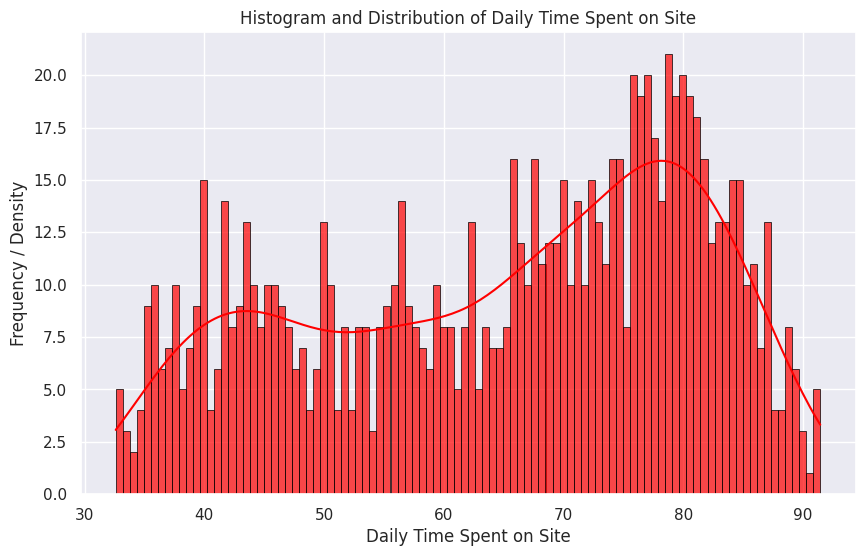

In [ ]:
#visualize the Average daily time (in minutes) spent on the site
visualize_hist("Daily Time Spent on Site")

In [ ]:
#Average daily time (in hours) spent on the site
data["Daily Hours Spent on Site"].value_counts().idxmax()

'More than 1 hour'

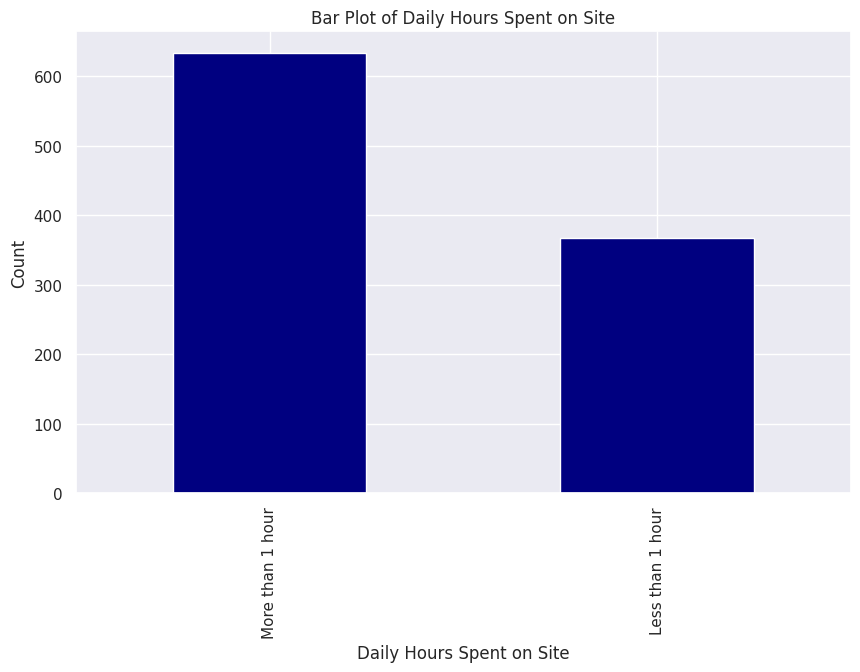

In [ ]:
#visualize the Average daily time (in hours) spent on the site
visualize_bar("Daily Hours Spent on Site")

In [ ]:
#average age of people visiting the site
round(data["Age"].mean(),0)

36.0

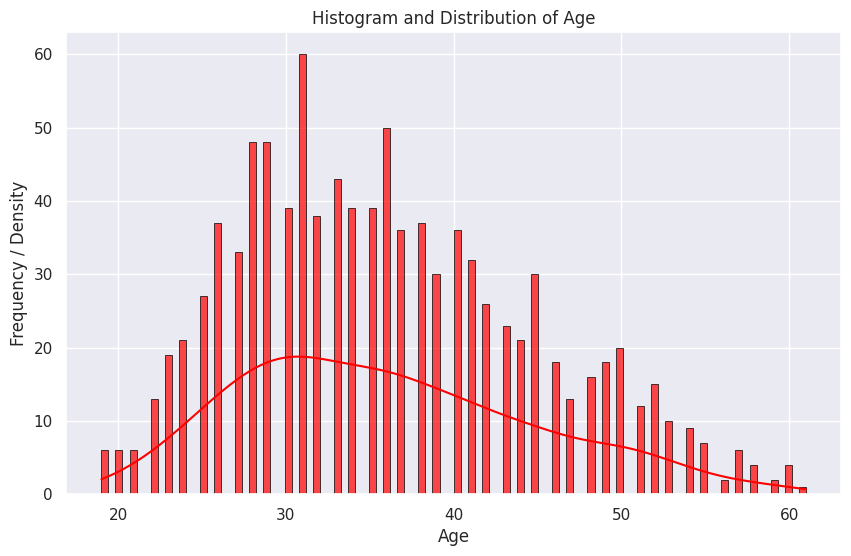

In [ ]:
#visualize the ages of people visiting the site
visualize_hist("Age")

In [ ]:
#Average Yearly income of the areas where users are located
round(data["Area Income"].mean(),2)

55000.0

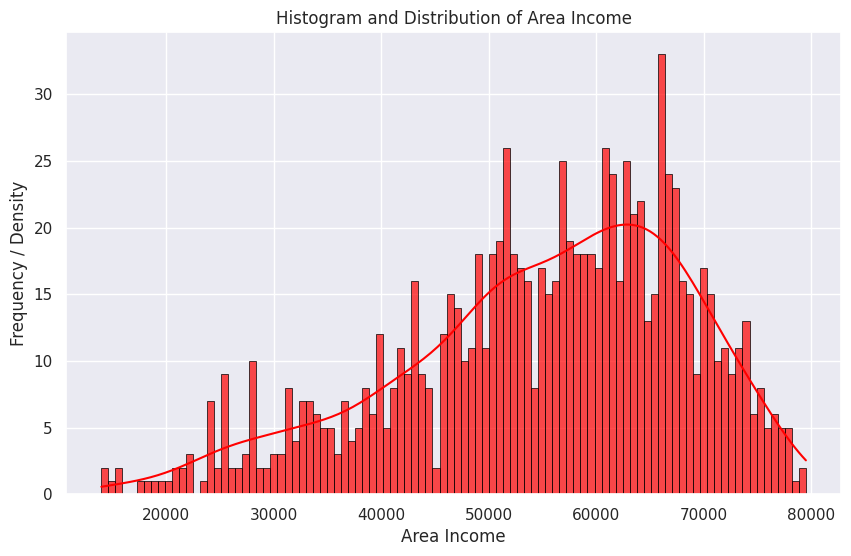

In [ ]:
#visualize The Distribition of Yearly income of the areas where users are located
visualize_hist("Area Income")

In [ ]:
#cities do most of the users come from
data["City"].value_counts().sort_values(ascending=False).head(5)

,count
City,
Lisamouth,3
Williamsport,3
Port Julie,2
South Lisa,2
Millertown,2


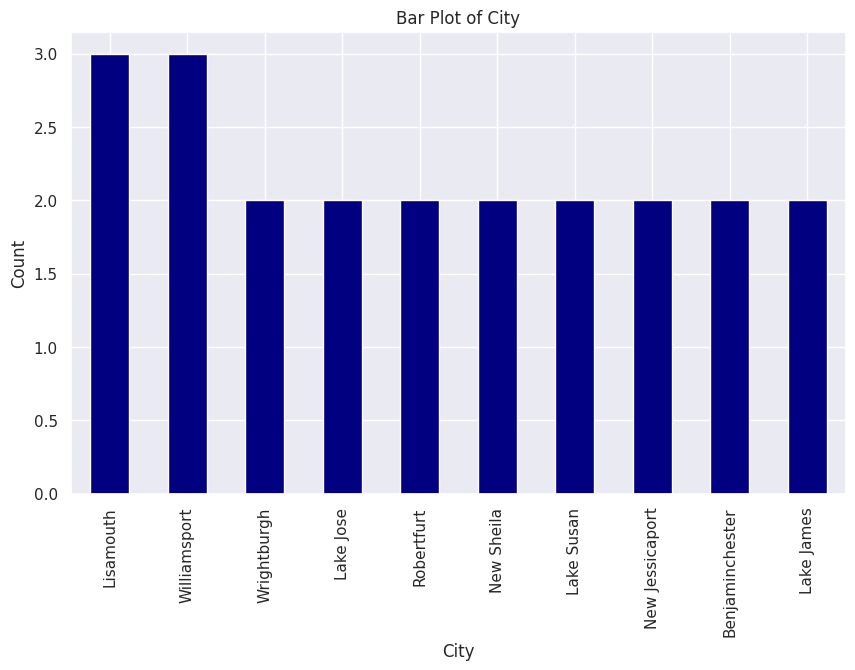

In [ ]:
#visualize the cities do most of the users come from
visualize_bar("City")

In [ ]:
#country do most of the users come from
data["Country"].value_counts().sort_values(ascending=False).head(5)

,count
Country,
France,9
Czech Republic,9
Australia,8
Afghanistan,8
Cyprus,8


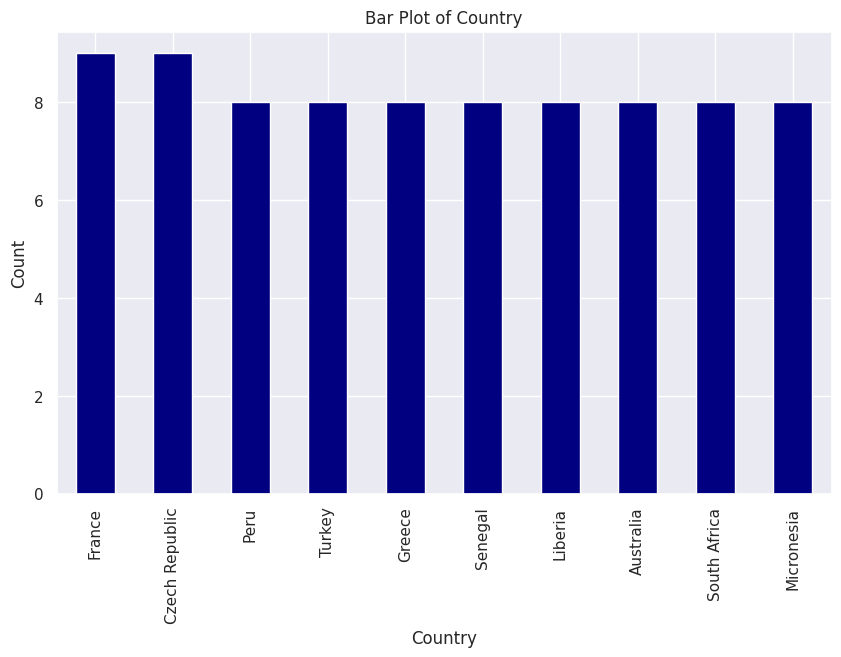

In [ ]:
#visualize the Countries do most of the users come from
visualize_bar("Country")

In [ ]:
#Most Gender Visit the site
data["Gender"].value_counts().idxmax()

'Female'

([<matplotlib.patches.Wedge at 0x7ef3ee657b20>,
 [Text(-0.0656202821455366, 1.0980409730839467, 'Female'),
  Text(0.06562028214553646, -1.0980409730839467, 'Male')],
 [Text(-0.03579288117029268, 0.5989314398639708, '51.9%'),
  Text(0.035792881170292605, -0.5989314398639708, '48.1%')])

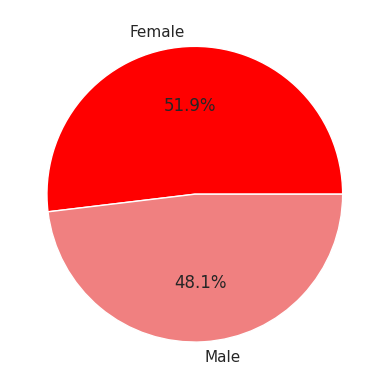

In [ ]:
#visualize the gender distribution of people visiting the site
gender_counts = data['Gender'].value_counts()
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%',colors=['red', 'lightcoral'])

In [ ]:
#month has the highest site usage activity
data["Month"].value_counts().idxmax()

'February'

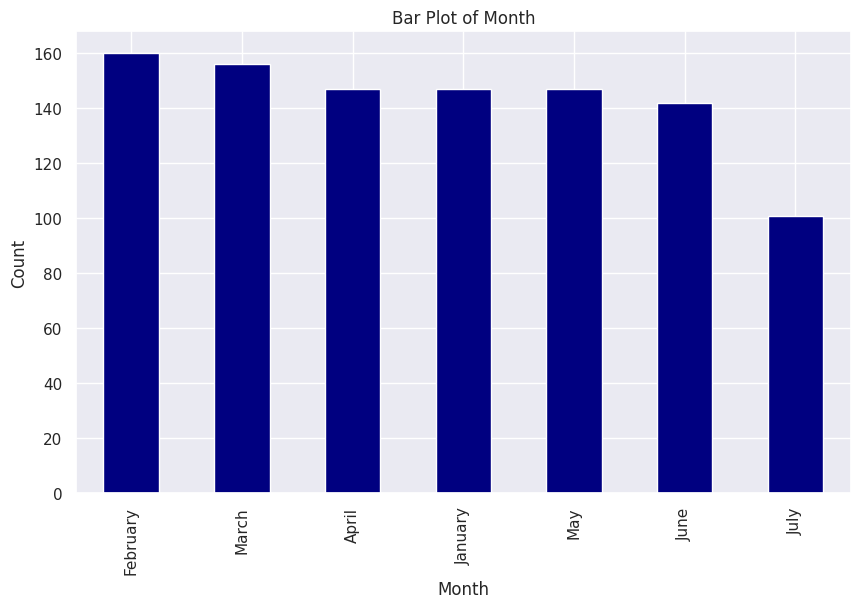

In [ ]:
#visualize the months has the highest site usage activity
visualize_bar("Month")

In [ ]:
#hour has the highest site usage activity
data["Hour"].value_counts().idxmax()

'7 AM'

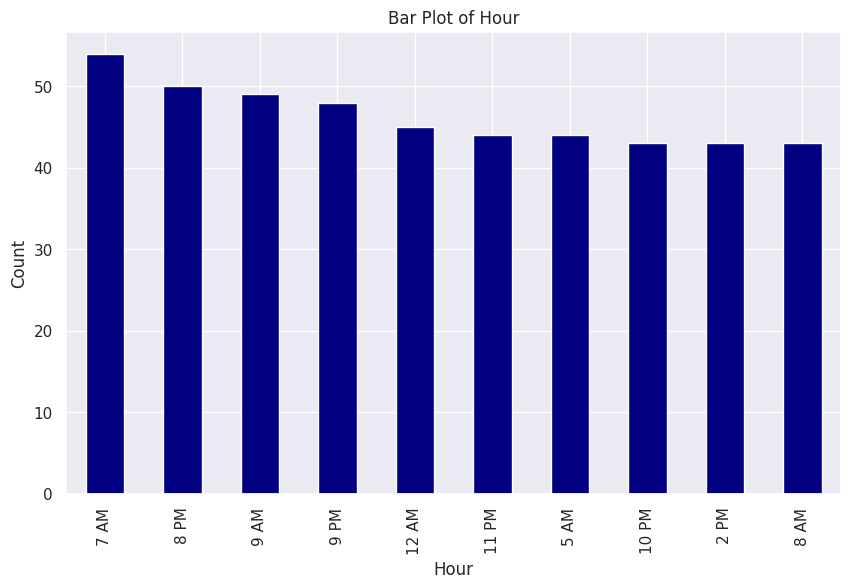

In [ ]:
#visualize the hours has the highest site usage activity
visualize_bar("Hour")

In [ ]:
#Average of Daily Internet Usage by users
print(f"{data['Daily Internet Usage'].mean()} GB")

180.0001 GB


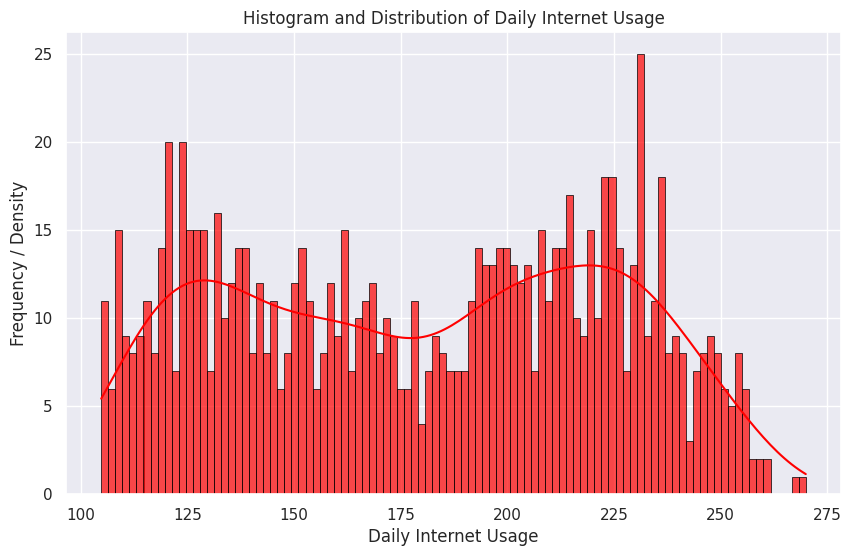

In [ ]:
#visualize The Distribition of Daily Internet Usage by users
visualize_hist('Daily Internet Usage')

 **Notes**:

* The average daily time spent on the site is between 67 and 87 minutes.
* The average age of visitors is 30.
* The average yearly income of users' areas is between $50,000 and $70,000.
* The cities with the most users are Lisamouth and Williamsport.
* The countries with the most users are France and Czech Republic.
* Most visitors are female.
* The months with the highest site usage are February and March.
* The hour with the highest site usage is 7 AM.
* The average daily internet usage by users is 180 GB.

## Bivariate Analysis




1. Check if there is a relationship between the Daily Internet Usage and the Daily Time Spent on Site.
2. Check if there is a relationship between the Gender and the Daily Time Spent on Site.
3. Check if there is a relationship between the Daily Time Spent on Site and the Age of people.
4. check if there is a relationship between the Daily Time Spent on Site and the Area Income people.


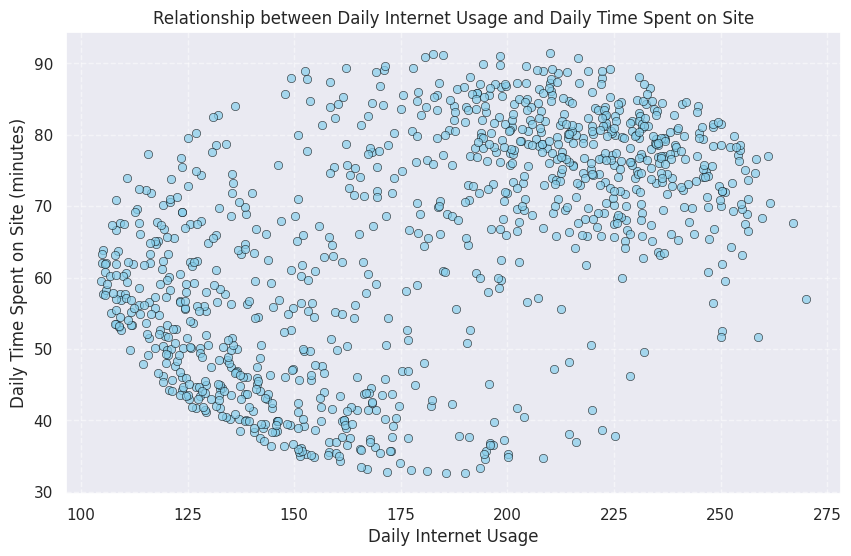

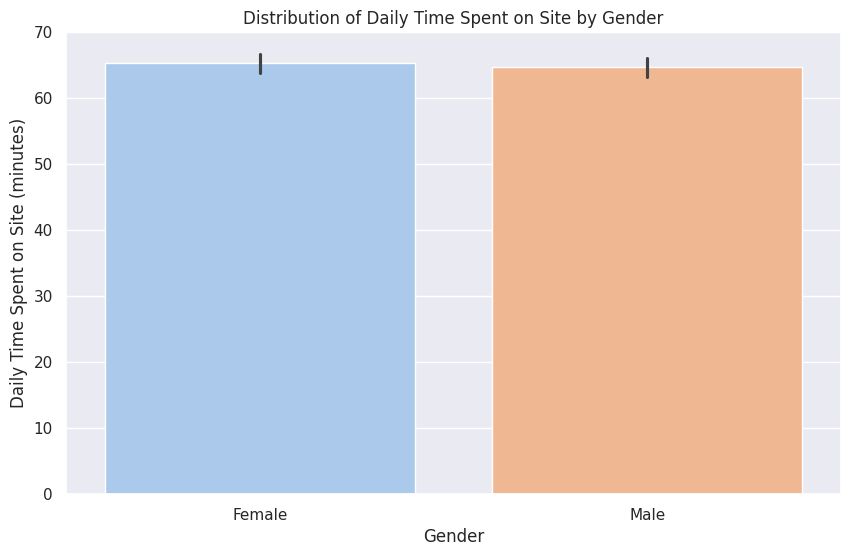

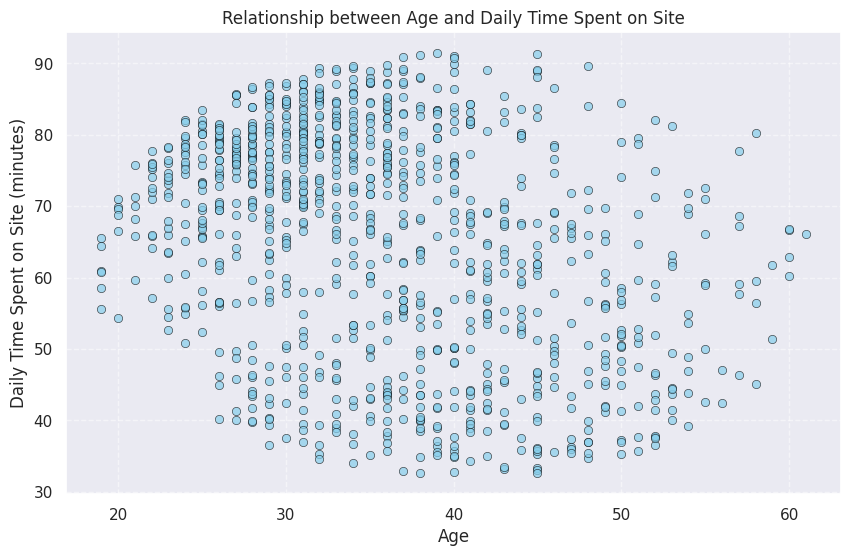

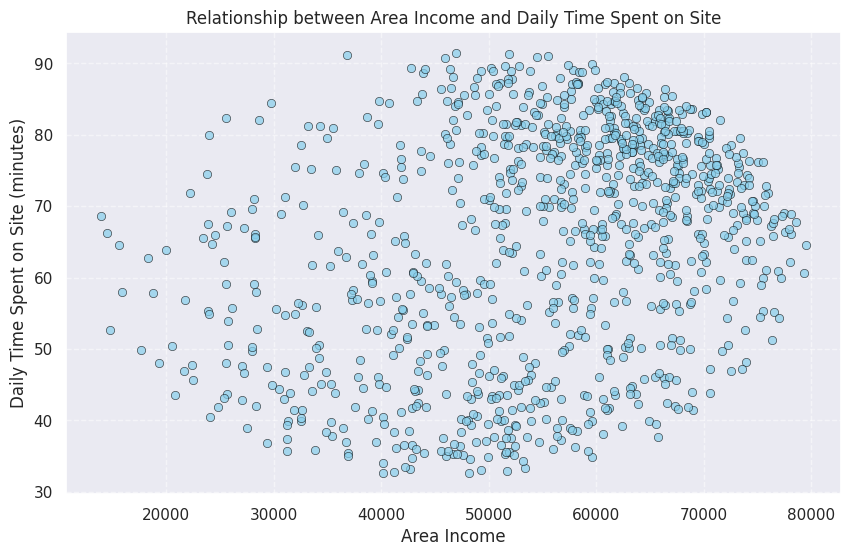

In [ ]:
# List of columns to compare with 'Daily Time Spent on Site'
columns = ['Daily Internet Usage', 'Gender', 'Age' , "Area Income"]

# Loop through the columns and visualize the relationships
for column in columns:
    plt.figure(figsize=(10, 6))

    if column == 'Gender':  # For categorical columns, use a barplot
        sns.barplot(x=data[column], y=data['Daily Time Spent on Site'], palette='pastel')
        plt.title(f"Distribution of Daily Time Spent on Site by {column}")
        plt.xlabel(column)
        plt.ylabel("Daily Time Spent on Site (minutes)")
    else:  # For numerical columns, use a scatter plot
        sns.scatterplot(x=data[column], y=data['Daily Time Spent on Site'], color='skyblue', edgecolor='black', alpha=0.7)
        plt.title(f"Relationship between {column} and Daily Time Spent on Site")
        plt.xlabel(column)
        plt.ylabel("Daily Time Spent on Site (minutes)")
        plt.grid(True, linestyle='--', alpha=0.5)

    plt.show()

**Notes**:
* There is a strong relationship between the Daily Internet Usage and the Daily Time Spent on Site,
where higher Daily Time corresponds to higher Internet Usage, and the same is true in reverse.
* There isn't a significant relationship between the Gender and the Daily Time Spent on Site,
although there is a slight difference for women, which is attributed to the higher number of women on the site.
* There is a relationship between the Daily Time Spent on Site and the Age of people,
where younger people tend to spend more time on the site.
Copy code
* There is a relationship between the Daily Time Spent on Site and the Area Income of people,
where areas with higher income tend to have individuals spending more time on the site.







## Time series analysis

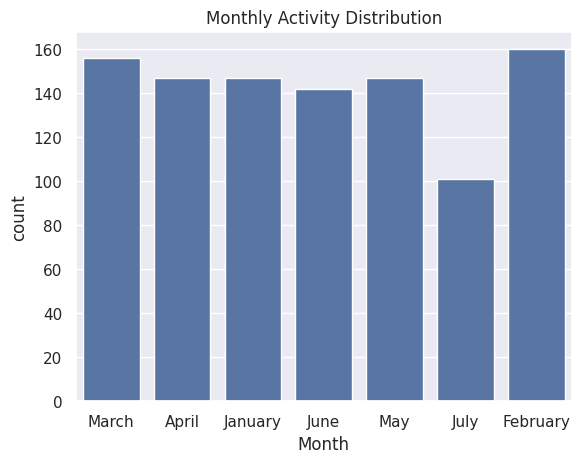

In [ ]:
# Distribution of activity by month
sns.countplot(x=data['Month'])
plt.title('Monthly Activity Distribution')
plt.show()

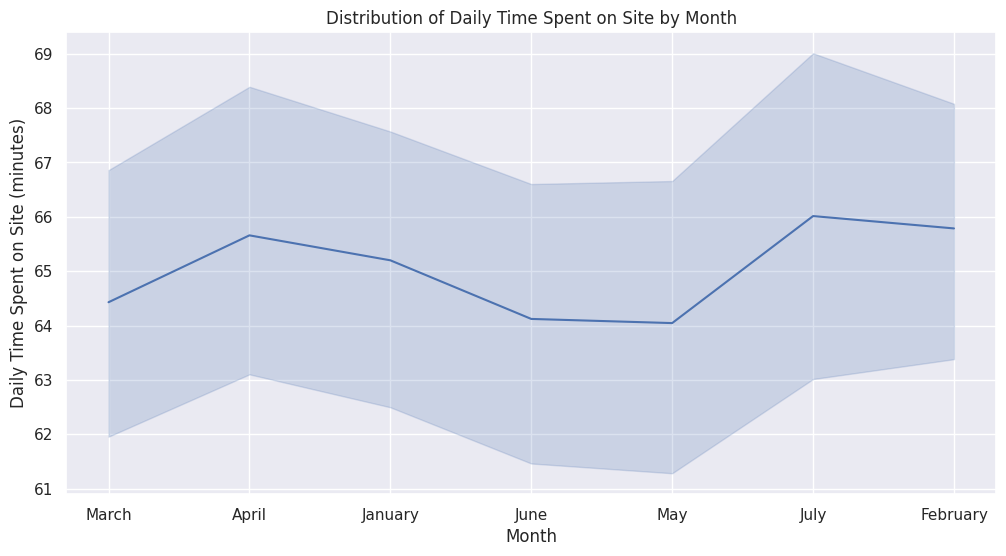

In [ ]:
# Visualize the relationship between Month and Daily Time Spent on Site
plt.figure(figsize=(12, 6))
sns.lineplot(x=data['Month'], y=data['Daily Time Spent on Site'], palette='coolwarm')
plt.title("Distribution of Daily Time Spent on Site by Month")
plt.xlabel("Month")
plt.ylabel("Daily Time Spent on Site (minutes)")
plt.show()

**Notes**:
* The highest Daily Time Spent on Site was observed in July,
despite July having the lowest distribution among all months.
This could suggest that July might have been a free month, allowing users to spend more time on the site.

# Target Distribition

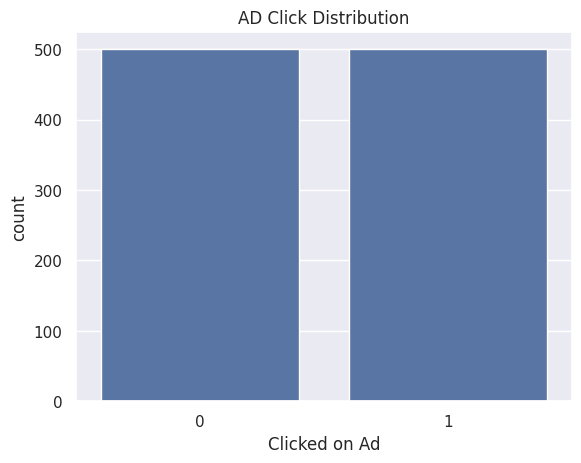

In [ ]:
# Distribution of Target
sns.countplot(x=data['Clicked on Ad'])
plt.title('AD Click Distribution')
plt.show()

* The target classes are balanced.
This allows us to consider metrics like accuracy, F1 score, and others without concern for class imbalance.


# Correlition with Target

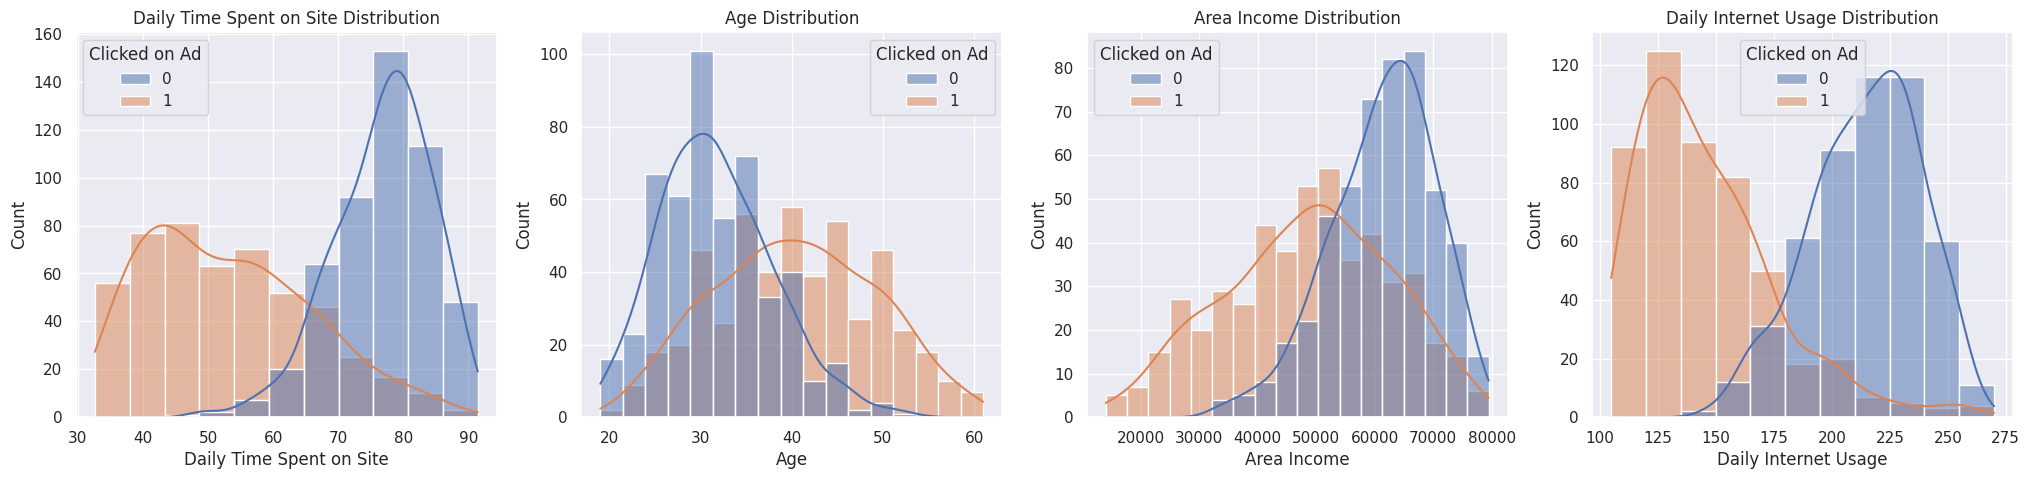

In [ ]:
num_features = data.select_dtypes(include=['int64', 'float64']).columns.drop("Clicked on Ad")

fig,ax = plt.subplots(1,len(num_features),figsize=(25,5))
for i,col in enumerate(num_features):
    sns.histplot(data=data,x=col,ax=ax[i],kde=True,hue='Clicked on Ad')
    ax[i].set_title(f'{col} Distribution')

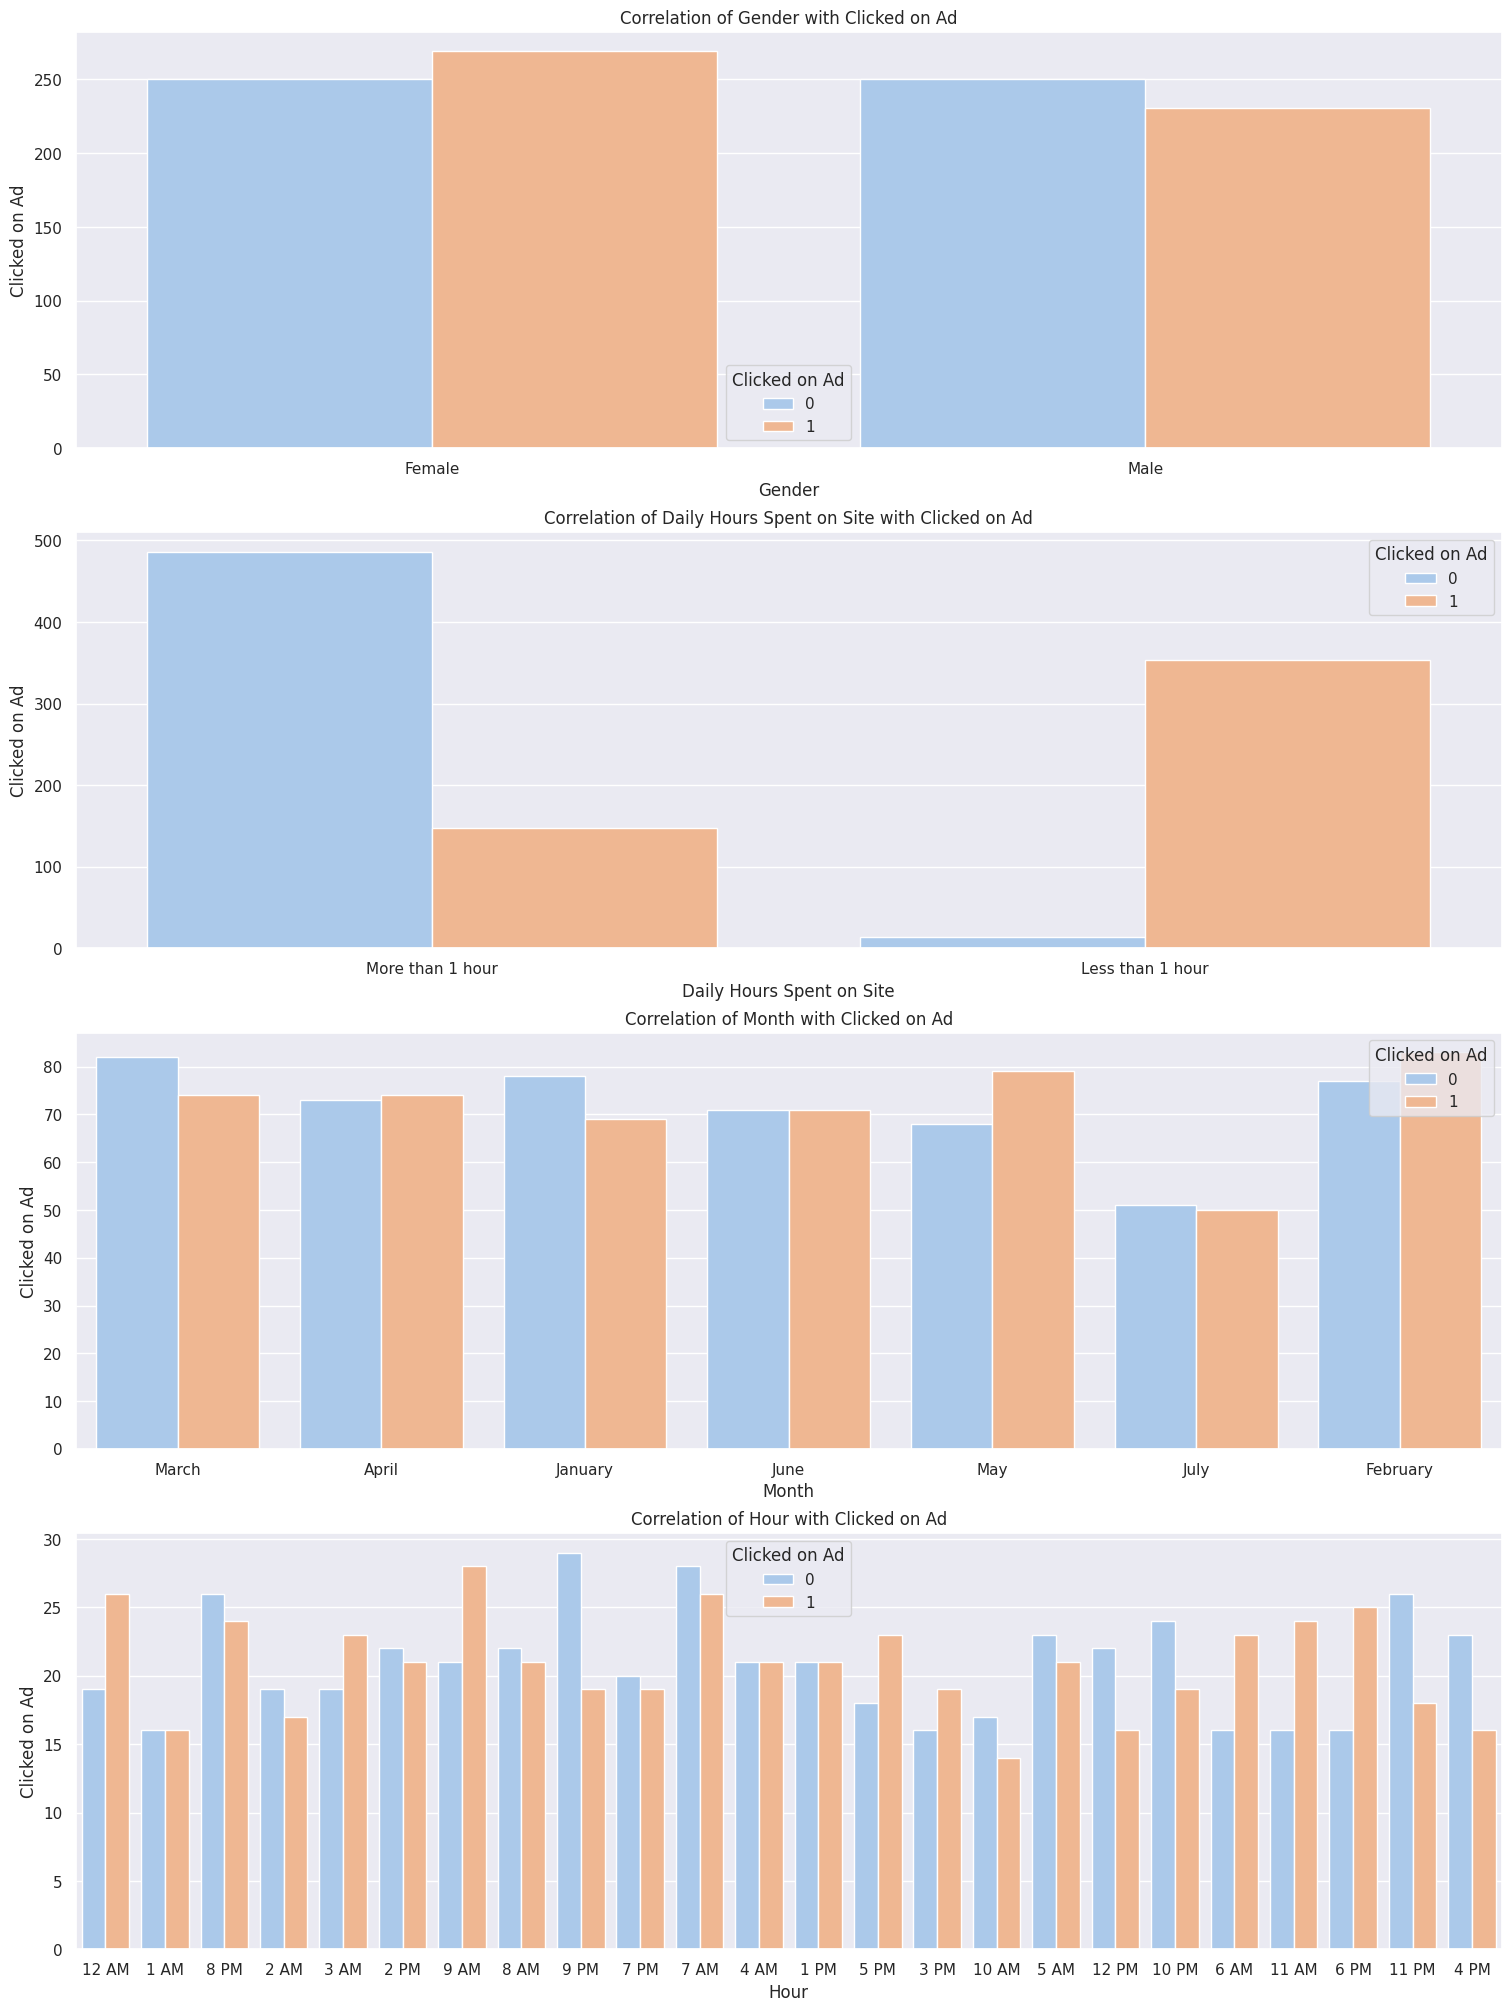

In [ ]:
# Selecting categorical features
cat_features = ["Gender",	"Daily Hours Spent on Site","Month","Hour"]

# Setting up subplots for categorical columns
fig, axes = plt.subplots(4, 1, figsize=(15, 20), constrained_layout=True)

# Loop through each categorical column and plot a boxplot
for i, col in enumerate(cat_features):
    sns.countplot(data=data, x=col, ax=axes[i], palette="pastel", hue="Clicked on Ad")
    axes[i].set_title(f"Correlation of {col} with Clicked on Ad")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Clicked on Ad")

# Show the plots
plt.show()


* I think most Features have a good correlition with the Target

<Axes: >

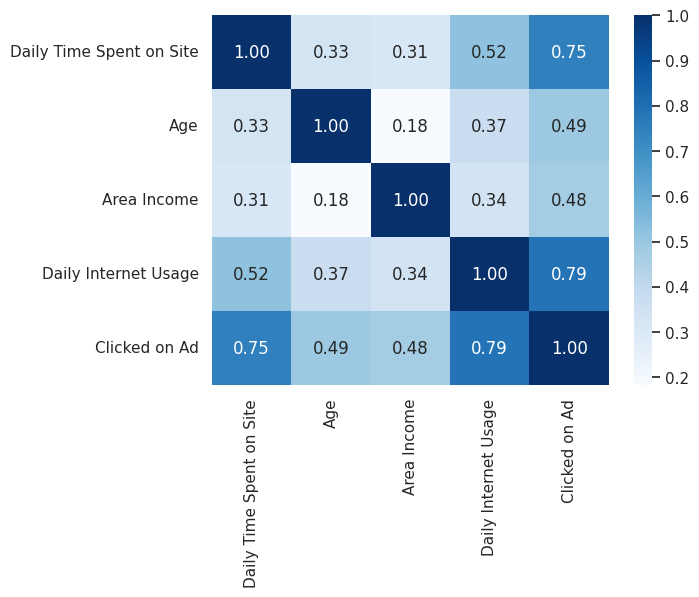

In [ ]:
sns.heatmap(data.select_dtypes(include='number').corr().abs(), annot=True, cmap='Blues', fmt='.2f')

* As observed, Most features exhibit a good correlation with the target (Clicked on Ad)

# Data Splitting and Preprocessing

In [ ]:
# Declare x and y
x = data.drop(['Clicked on Ad', 'Timestamp', 'Country'], axis=1)
y = data['Clicked on Ad']
print(x.shape)
print(y.shape)

(1000, 10)
(1000,)


In [ ]:
# Split the data into training and testing sets (e.g., 80% train, 20% test)
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=42)

print("Training feature set:", xtrain.shape)
print("Testing feature set:", xtest.shape)
print("Training target set:", ytrain.shape)
print("Testing target set:", ytest.shape)

Training feature set: (800, 10)
Testing feature set: (200, 10)
Training target set: (800,)
Testing target set: (200,)


In [ ]:
# Numeric columns
num_cols = x.select_dtypes(include=['int64', 'float64']).columns

# Categorical columns
cat_cols = x.select_dtypes(include="object").columns

# Ensure correct columns are passed to the right pipelines
preprocessor = make_column_transformer((StandardScaler(), num_cols),
                                       (BinaryEncoder(), cat_cols))

# Fit and transform training data
xtrain = preprocessor.fit_transform(xtrain)

# Transform test data
xtest = preprocessor.transform(xtest)

# Model Building

1. We Need To declare function to validate The Model
2. We Need To declare function to Tunning The Model
3. We Need To declare Function to Check Model Evaluation.

In [ ]:
#declare function to validata The Model
def validate(model,x,y,score,n):

    '''this function is to validate the model across multiple stratified splits'''

    validate = cross_val_score(model , x , y , scoring=score , cv=n)
    print('Cross Validation Scores: ',validate)
    print('Scores Mean: ',validate.mean())
    model.fit(x,y)
    return model

In [ ]:
#declare function to Tunning The Model
def tunning(model,x,y,params,score,n):

    '''This function recieves a model then tune it using GridSearch
    then print the best parameters and return the best estimator'''

    grid = GridSearchCV(model,params,cv=n,scoring=score)
    grid.fit(x,y)
    best_model = grid.best_estimator_
    print("best Params : " , grid.best_params_)
    print("best Score : " , grid.best_score_)
    return best_model

In [ ]:
#declare Function to Check Model Evaluation
def model_evaluation(model,x,y,color):

    '''this function is to evaluate the model based on a given threshold
    1--> print the classification report     2--> display the confusion matrix'''

    y_pred = model.predict(x)

    #classification report
    print("Classification Report:")
    print(classification_report(y, y_pred, zero_division=0))

    #confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y, y_pred), annot=True , fmt="d", cmap=color, cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

# 1.Logistic Regression

In [ ]:
#validate
log = LogisticRegression(random_state=42)
log_reg = validate(log , xtrain , ytrain , "f1" , 10)
log_reg

Cross Validation Scores:  [0.98666667 0.98701299 0.975      0.98734177 0.95       0.96
 0.93333333 0.97368421 0.97368421 0.96202532]
Scores Mean:  0.9688748496673213


LogisticRegression(random_state=42)

In [ ]:
#Define the parameter grid
params = {'penalty': ['l1', 'l2', 'elasticnet'],
              'C': [0.01, 0.1, 1, 10],
              'solver': ['saga', 'liblinear']}

#Tunning The Model
best_log = tunning(log_reg , xtrain , ytrain , params , "f1" , 5)
best_log

best Params :  {'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}
best Score :  0.9722624706479405


LogisticRegression(C=0.1, penalty='l1', random_state=42, solver='saga')

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       411
           1       0.99      0.96      0.98       389

    accuracy                           0.98       800
   macro avg       0.98      0.98      0.98       800
weighted avg       0.98      0.98      0.98       800



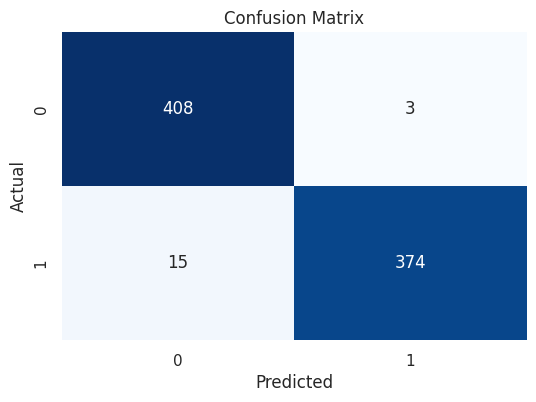

In [ ]:
#Model Evaluation for Training
model_evaluation(best_log , xtrain , ytrain , 'Blues')

# 2.Support Vector Classifier

In [ ]:
#validate
svc = SVC(probability=True , random_state=42)
svc = validate(svc , xtrain , ytrain , "f1" , 10)
svc

Cross Validation Scores:  [0.98666667 0.96       0.98734177 0.98734177 0.94871795 0.93333333
 0.92105263 0.96       0.97368421 0.97435897]
Scores Mean:  0.9632497309485984


SVC(probability=True, random_state=42)

In [ ]:
#Define the parameter grid
params = {'C': [0.01, 0.1, 1, 10, 100],
          'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
          'gamma': ['scale', 'auto', 0.01, 0.1, 1],
          'degree': [2, 3, 4]}

#Tunning The Model
best_svc = tunning(svc , xtrain , ytrain , params , "f1" , 5)
best_svc

best Params :  {'C': 10, 'degree': 2, 'gamma': 0.01, 'kernel': 'rbf'}
best Score :  0.9724605843423924


SVC(C=10, degree=2, gamma=0.01, probability=True, random_state=42)

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       411
           1       0.99      0.97      0.98       389

    accuracy                           0.98       800
   macro avg       0.98      0.98      0.98       800
weighted avg       0.98      0.98      0.98       800



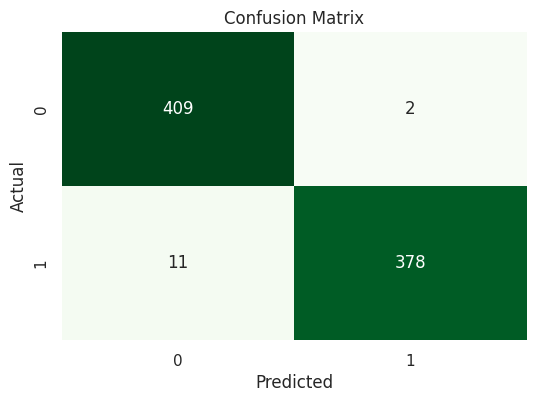

In [ ]:
#Model Evaluation for Training
model_evaluation(best_svc , xtrain , ytrain , 'Greens')

# 3.KNN Classifier

In [ ]:
#validate
knn = KNeighborsClassifier(n_neighbors=5)
knn = validate(knn , xtrain , ytrain , "f1" , 10)
knn

Cross Validation Scores:  [0.94444444 0.94594595 0.96296296 0.98701299 0.94594595 0.91891892
 0.90666667 0.94594595 0.97368421 0.94594595]
Scores Mean:  0.9477473974316079


KNeighborsClassifier()

In [ ]:
#Define the parameter grid
param = {'n_neighbors': np.arange(1, 21, 2)}

#Tunning The Model
best_knn = tunning(knn , xtrain , ytrain , param , "f1" , 5)
best_knn

best Params :  {'n_neighbors': 11}
best Score :  0.965291032508717


KNeighborsClassifier(n_neighbors=11)

Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       411
           1       1.00      0.94      0.97       389

    accuracy                           0.97       800
   macro avg       0.97      0.97      0.97       800
weighted avg       0.97      0.97      0.97       800



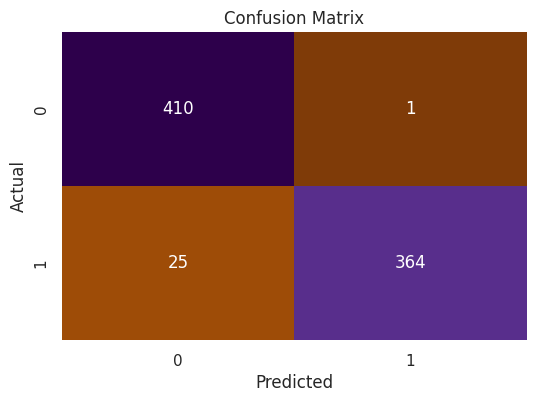

In [ ]:
#Model Evaluation
model_evaluation(best_knn , xtrain , ytrain , 'PuOr')

# 4.Decision Tree Classifier

In [ ]:
#validate
tree = DecisionTreeClassifier(random_state=42)
tree = validate(tree , xtrain , ytrain , "f1" , 10)
tree

Cross Validation Scores:  [0.95890411 0.96103896 0.95121951 0.98734177 0.925      0.89156627
 0.93333333 0.96       0.90909091 0.96103896]
Scores Mean:  0.9438533823498465


DecisionTreeClassifier(random_state=42)

In [ ]:
#Define the parameter grid
params = {'criterion': ['gini', 'entropy'],
          'max_depth':  np.arange(1,10),
          'min_samples_split':  np.arange(2,10)}

#Tunning The Model
best_tree = tunning(tree , xtrain , ytrain , params , "f1" , 5)
best_tree

best Params :  {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 9}
best Score :  0.9535066695926838


DecisionTreeClassifier(max_depth=5, min_samples_split=9, random_state=42)

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       411
           1       0.99      0.97      0.98       389

    accuracy                           0.98       800
   macro avg       0.98      0.98      0.98       800
weighted avg       0.98      0.98      0.98       800



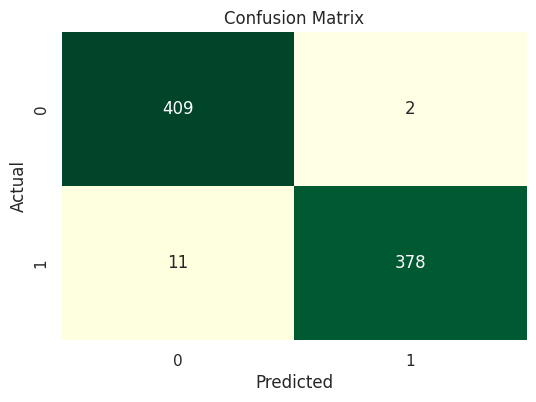

In [ ]:
#Model Evaluation
model_evaluation(best_tree , xtrain , ytrain , 'YlGn')

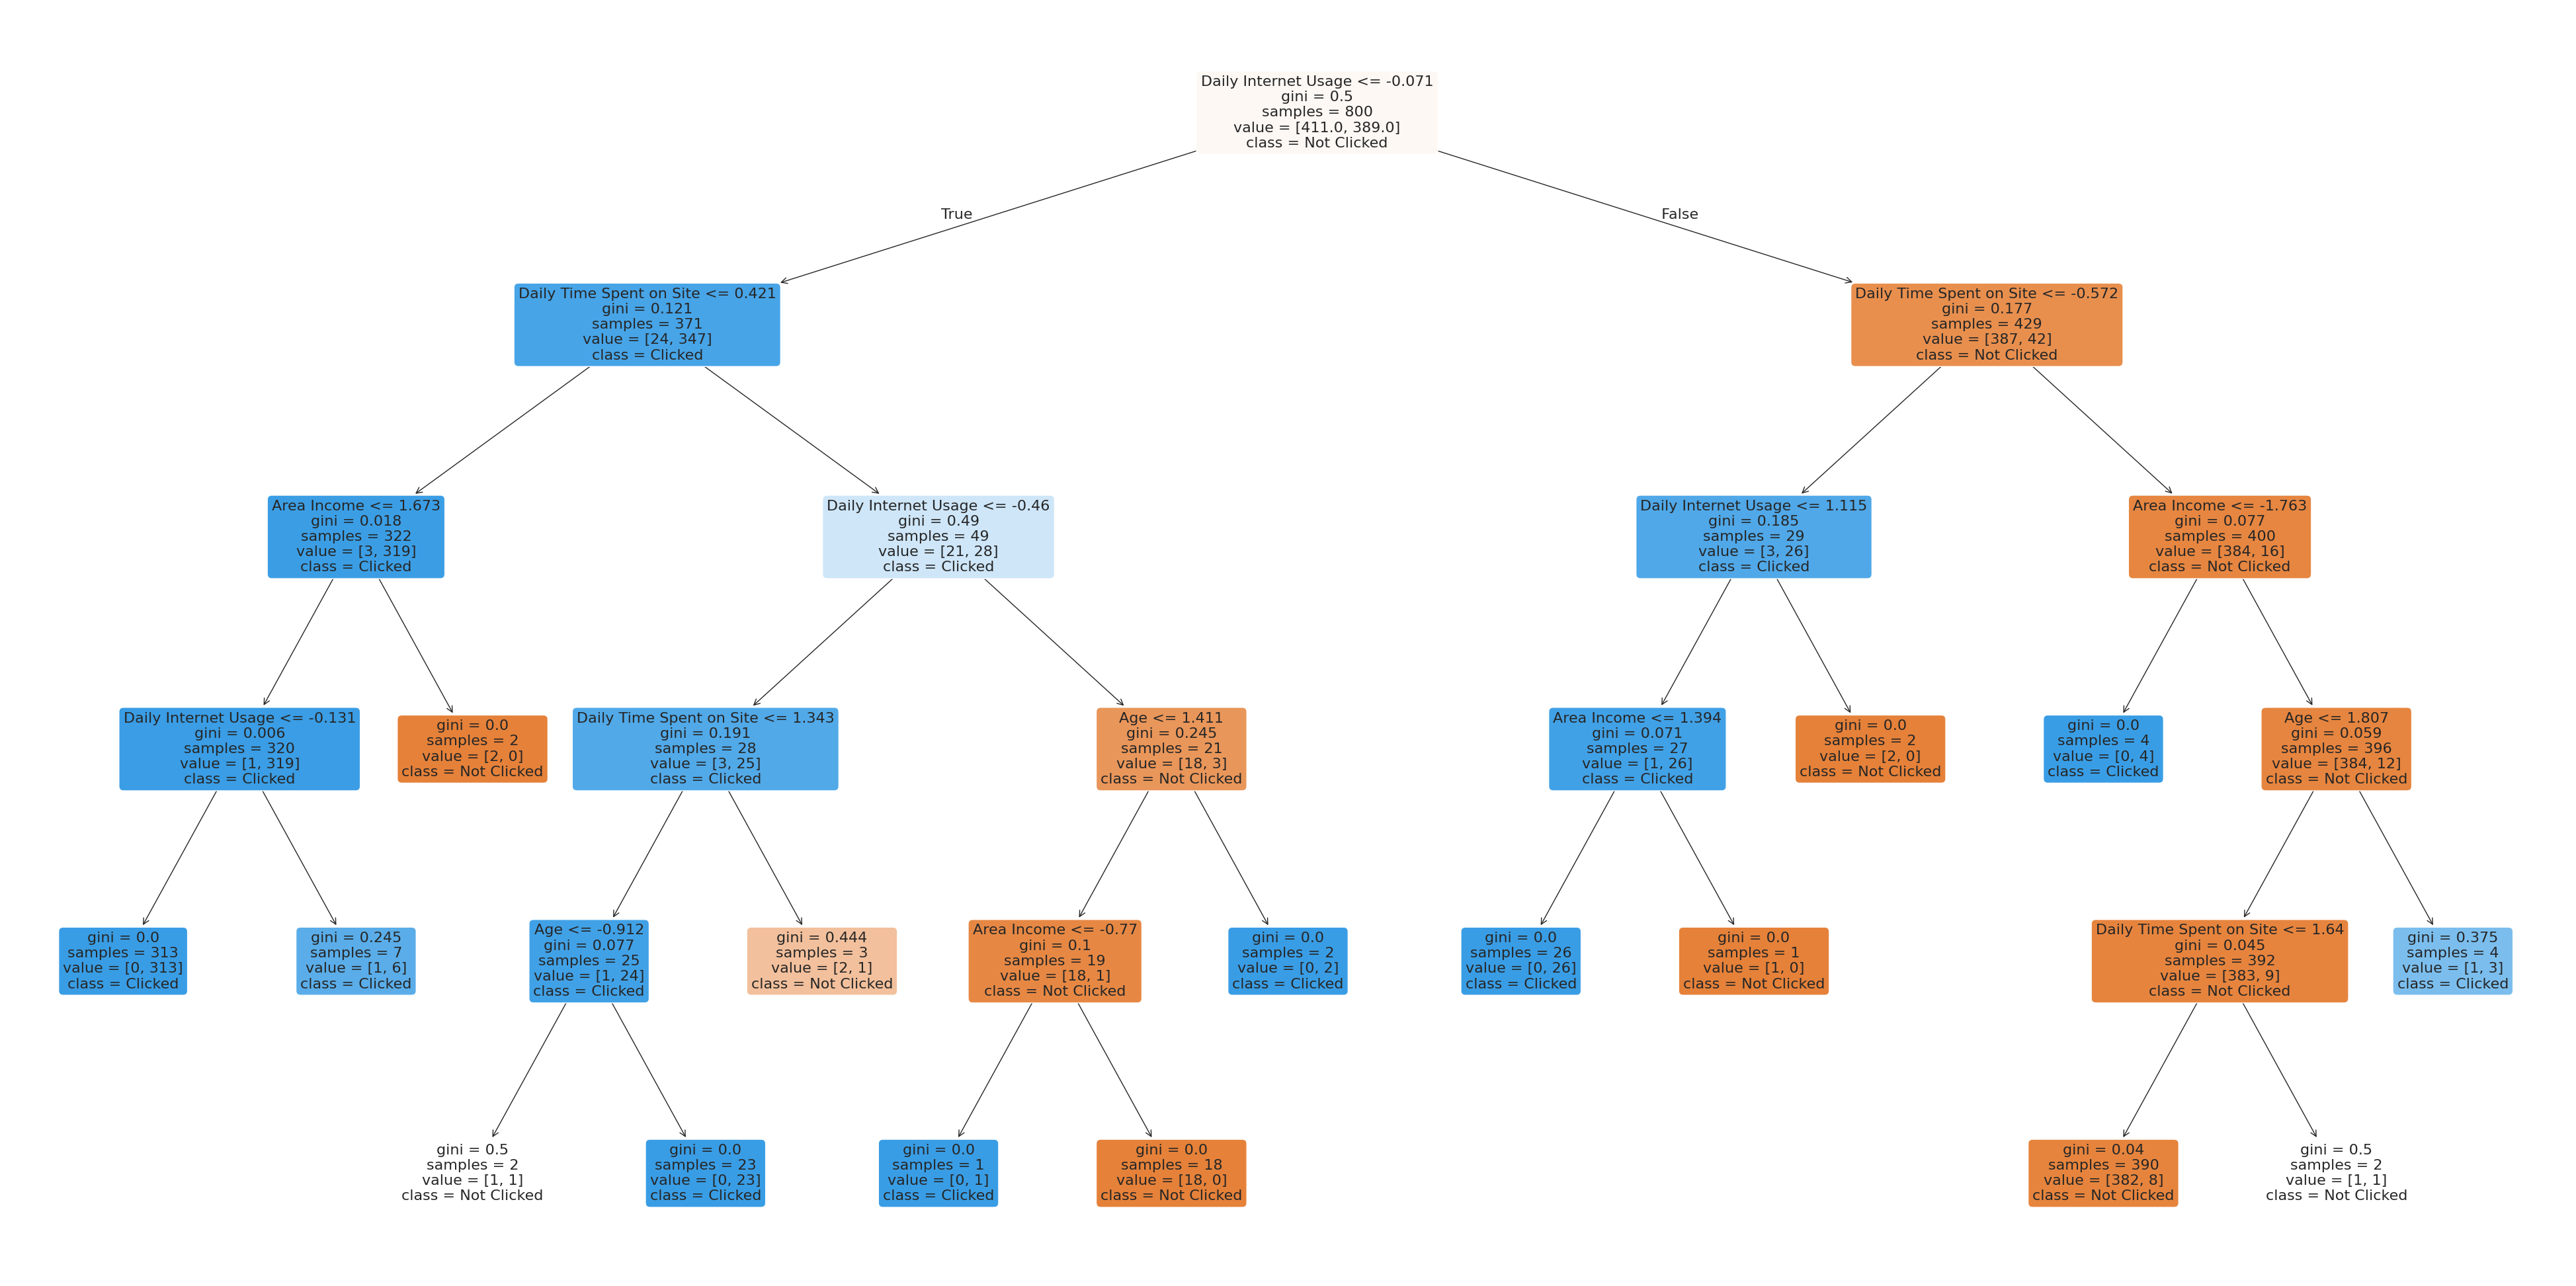

In [ ]:
plt.figure(figsize=(50,25))
plot_tree(best_tree, feature_names = x.columns, class_names=['Not Clicked','Clicked'],filled=True, rounded=True,fontsize=16);

# 5. Voting Classifier

In [ ]:
#Define the Voting Classifier
vot_cl = VotingClassifier(estimators=[
    ("log_reg", best_log),
    ("svc", best_svc),
    ("knn", best_knn),
    ("tree", best_tree)])

vot_cl

VotingClassifier(estimators=[('log_reg',
                              LogisticRegression(C=0.1, penalty='l1',
                                                 random_state=42,
                                                 solver='saga')),
                             ('svc',
                              SVC(C=10, degree=2, gamma=0.01, probability=True,
                                  random_state=42)),
                             ('knn', KNeighborsClassifier(n_neighbors=11)),
                             ('tree',
                              DecisionTreeClassifier(max_depth=5,
                                                     min_samples_split=9,
                                                     random_state=42))])

In [ ]:
#validate
vot_cl = validate(vot_cl , xtrain , ytrain , "f1" , 10)
vot_cl

Cross Validation Scores:  [0.97297297 0.97368421 1.         1.         0.98701299 0.94594595
 0.93150685 0.94594595 0.97368421 0.97368421]
Scores Mean:  0.9704437332771866


VotingClassifier(estimators=[('log_reg',
                              LogisticRegression(C=0.1, penalty='l1',
                                                 random_state=42,
                                                 solver='saga')),
                             ('svc',
                              SVC(C=10, degree=2, gamma=0.01, probability=True,
                                  random_state=42)),
                             ('knn', KNeighborsClassifier(n_neighbors=11)),
                             ('tree',
                              DecisionTreeClassifier(max_depth=5,
                                                     min_samples_split=9,
                                                     random_state=42))])

In [ ]:
#Define the parameter grid
param = {'voting': ['hard', 'soft']}

#Tunning The Model
best_vot_cl = tunning(vot_cl , xtrain , ytrain , param , "f1" , 5)
best_vot_cl

best Params :  {'voting': 'hard'}
best Score :  0.9760853926613342


VotingClassifier(estimators=[('log_reg',
                              LogisticRegression(C=0.1, penalty='l1',
                                                 random_state=42,
                                                 solver='saga')),
                             ('svc',
                              SVC(C=10, degree=2, gamma=0.01, probability=True,
                                  random_state=42)),
                             ('knn', KNeighborsClassifier(n_neighbors=11)),
                             ('tree',
                              DecisionTreeClassifier(max_depth=5,
                                                     min_samples_split=9,
                                                     random_state=42))])

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       411
           1       1.00      0.96      0.98       389

    accuracy                           0.98       800
   macro avg       0.98      0.98      0.98       800
weighted avg       0.98      0.98      0.98       800



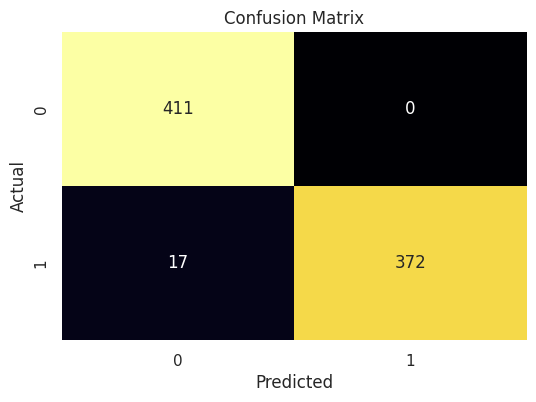

In [ ]:
#Model Evaluation
model_evaluation(best_vot_cl , xtrain , ytrain , 'inferno')

# 6.Random Forest Classifier

In [ ]:
# Define the Random Forest Classifier
forest = RandomForestClassifier(n_estimators=500,max_depth=best_tree.max_depth,random_state=42)
forest

RandomForestClassifier(max_depth=5, n_estimators=500, random_state=42)

In [ ]:
#validate
forest = validate(forest , xtrain , ytrain , "f1" , 10)
forest

Cross Validation Scores:  [0.96       0.94594595 0.98734177 1.         0.96103896 0.94871795
 0.92105263 0.96103896 0.97435897 0.92307692]
Scores Mean:  0.958257211790856


RandomForestClassifier(max_depth=5, n_estimators=500, random_state=42)

In [ ]:
#Define the parameter grid
params = {'criterion': ['gini', 'entropy'],
          'min_samples_split':  np.arange(2,10)}

#Tunning The Model
best_forest = tunning(forest , xtrain , ytrain , params , "f1" , 5)
best_forest

best Params :  {'criterion': 'gini', 'min_samples_split': 2}
best Score :  0.9556552013312754


RandomForestClassifier(max_depth=5, n_estimators=500, random_state=42)

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       411
           1       1.00      0.97      0.98       389

    accuracy                           0.98       800
   macro avg       0.98      0.98      0.98       800
weighted avg       0.98      0.98      0.98       800



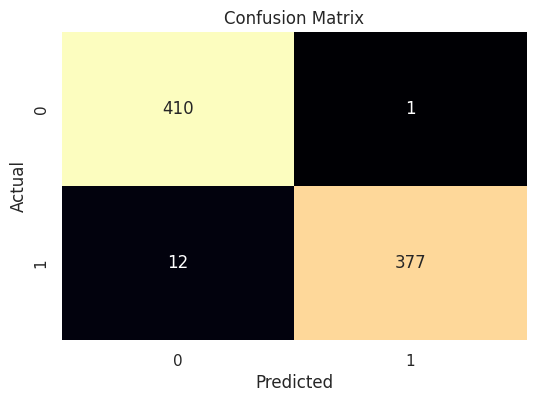

In [ ]:
#Model Evaluation
model_evaluation(best_forest , xtrain , ytrain , 'magma')

# 7.AdaBoost Classifier

In [ ]:
#define the AdaBoost Classifier
adaboost = AdaBoostClassifier(best_tree,n_estimators=100,random_state=42)
adaboost

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=5,
                                                    min_samples_split=9,
                                                    random_state=42),
                   n_estimators=100, random_state=42)

In [ ]:
#validate
adaboost = validate(adaboost , xtrain , ytrain , "f1" , 10)
adaboost

Cross Validation Scores:  [0.98666667 0.96       0.98734177 1.         0.96202532 0.96103896
 0.92105263 0.97368421 0.98701299 0.97435897]
Scores Mean:  0.9713181519790448


AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=5,
                                                    min_samples_split=9,
                                                    random_state=42),
                   n_estimators=100, random_state=42)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       411
           1       1.00      1.00      1.00       389

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800



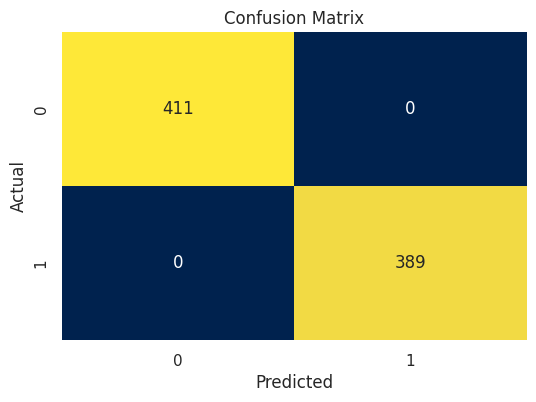

In [ ]:
#Model Evaluation
model_evaluation(adaboost , xtrain , ytrain , 'cividis')

* Check if the model is underfitting

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92        89
           1       0.95      0.92      0.94       111

    accuracy                           0.93       200
   macro avg       0.93      0.93      0.93       200
weighted avg       0.93      0.93      0.93       200



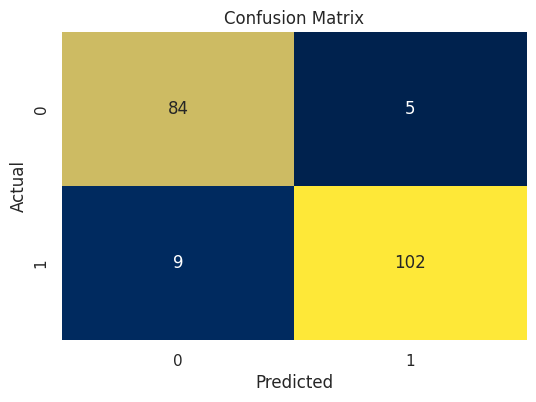

In [ ]:
#Model Evaluation on Testing
model_evaluation(adaboost , xtest , ytest , 'cividis')

# 8.XGBoost Classifier

In [ ]:
#define the XGBoost Classifier
xgb_clf = XGBClassifier(n_estimators = 100 ,n_jobs = -1 ,random_state = 42)
xgb_clf

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:
#validate
xgb_clf = validate(xgb_clf , xtrain , ytrain , "f1" , 10)
xgb_clf

Cross Validation Scores:  [0.96       0.96       0.975      0.98734177 0.95       0.96103896
 0.90909091 0.94736842 0.97368421 0.97368421]
Scores Mean:  0.959720848438703


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:
#Define the parameter grid
params = {'n_estimators': [50, 100, 200],
          'learning_rate': [0.01, 0.1, 0.2],
          'max_depth': np.arange(1,10),
          'subsample': [0.6, 0.8, 1.0]}

#Tunning The Model
best_xgb_clf = tunning(xgb_clf , xtrain , ytrain , params , "f1" , 5)
best_xgb_clf

best Params :  {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 200, 'subsample': 0.8}
best Score :  0.9625999719779548


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       411
           1       1.00      1.00      1.00       389

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800



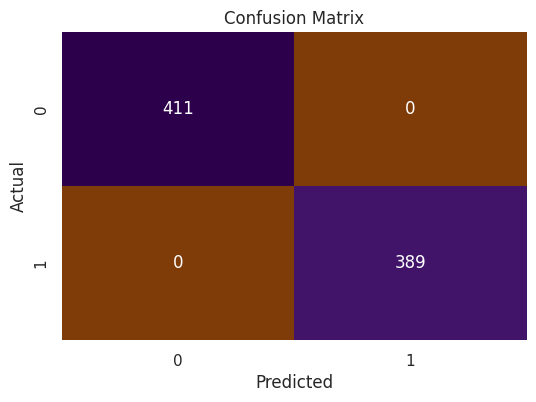

In [ ]:
#Model Evaluation
model_evaluation(best_xgb_clf , xtrain , ytrain , 'PuOr')

* Since all models are nearly equal in accuracy, we need to perform model evaluation on the test set for best 3 models on Train.

# Testing

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92        89
           1       0.95      0.92      0.94       111

    accuracy                           0.93       200
   macro avg       0.93      0.93      0.93       200
weighted avg       0.93      0.93      0.93       200



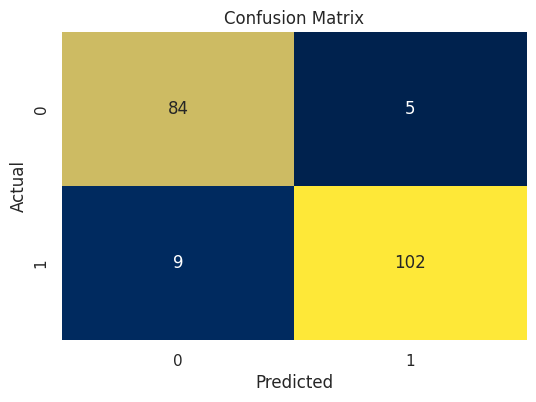

In [ ]:
#AdaBoost Model Evaluation on Testing
model_evaluation(adaboost , xtest , ytest , 'cividis')

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.92      0.93        89
           1       0.94      0.95      0.94       111

    accuracy                           0.94       200
   macro avg       0.93      0.93      0.93       200
weighted avg       0.93      0.94      0.93       200



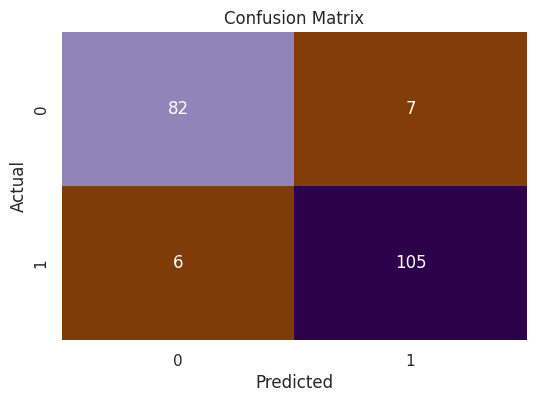

In [ ]:
#XGBoost Model Evaluation on Testing
model_evaluation(best_xgb_clf , xtest , ytest , 'PuOr')

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94        89
           1       0.95      0.96      0.96       111

    accuracy                           0.95       200
   macro avg       0.95      0.95      0.95       200
weighted avg       0.95      0.95      0.95       200



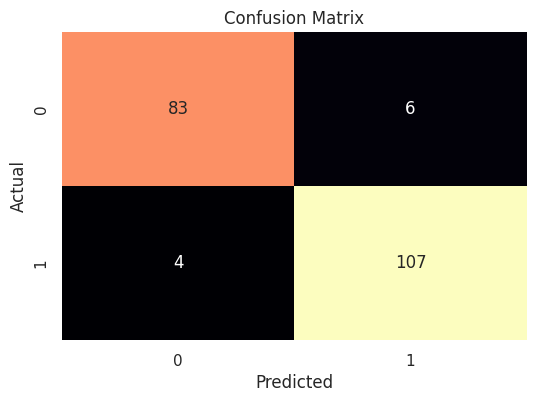

In [ ]:
#Random Forest Model Evaluation on Testing
model_evaluation(best_forest , xtest , ytest , 'magma')

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        89
           1       0.95      0.95      0.95       111

    accuracy                           0.94       200
   macro avg       0.94      0.94      0.94       200
weighted avg       0.94      0.94      0.94       200



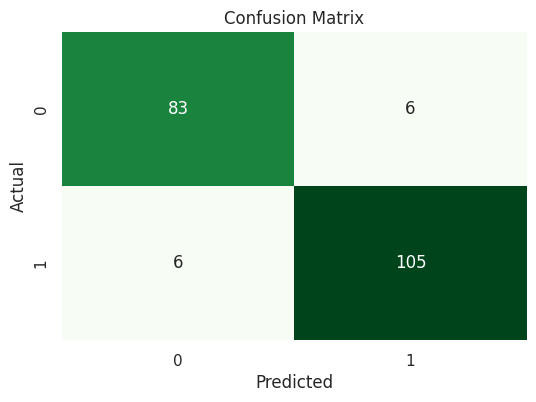

In [ ]:
#SVC Model Evaluation for Training
model_evaluation(best_svc , xtest , ytest , 'Greens')

# Conclusion
* The best estimator is Random Forest Classifier with f1 score of 98*% on training set and 96% on test set.
* Daily internet usage and Daily time spent on site have very strong correlation with the target.
* Age and Area income have good correlation with the target.